## Stochastic Vairationl Inference for GPRN

This notebook illustrates implementation of GPRN (Wislon, 2011) with SVI inference for Jura dataset. Swiss Jura dataset consists of geo-spatial measurements of metals Ni Cd and Zn in the Swiss region of Jura. This can be modeled using mutli-response regression methods.

The dataset can be found here :https://sites.google.com/site/goovaertspierre/pierregoovaertswebsite/download/jura-data

** Module and data imports **

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import logging
import time
import sys
from scipy.cluster.vq import kmeans
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from numpy.random import RandomState
rng = RandomState(1231)
%matplotlib inline


float_type = tf.float64
jitter_level = 1e-5
tf.logging.set_verbosity(tf.logging.WARN)

# define model chekpoint path & tensorboard path 
modelPath = "models/gprn.ckpt"
tbPath    = "models/tbgprn/"

In [2]:
# main module imports
from onofftf.main import Param, DataSet, GaussKL, KernSE, GPConditional
from onofftf.utils import modelmanager
from gpflow import transforms

from onofftf.gprn import build_prior_kl,build_predict,variational_expectations,generate_train_op,plot_gprn_fit

In [3]:
# define trian and test splits
traindf = pd.read_csv("data/train.csv")
testdf  = pd.read_csv("data/test.csv")

Xtrain = traindf[['x', 'y']].as_matrix()
Ytrain = traindf[['cd','ni','zn']].as_matrix()

Xtest = testdf[['x', 'y']].as_matrix()
Ytest = testdf[['cd','ni','zn']].as_matrix()

In [4]:
# DataSet object gives easy access for mini-batches over epochs
train_data = DataSet(Xtrain,Ytrain)

** Modeling specifications**

In [5]:
###############################################
num_iter      = 30000           # optimization iterations
num_minibatch = 220             # mini-batch size
num_output    = Ytrain.shape[1] # number of responses
num_latent    = 2               # number of latent functions 
num_data      = Xtrain.shape[0] # number of observations 
qf_diag       = True            # diagnoal approx for variational posterior
qw_diag       = True


num_inducing_f = [10            # number of inducing points for latent function \f
                  for i in range(num_latent)]

num_inducing_w = [[10           # number of inducing points for weight matrix components W
                   for i in range(num_output)]
                   for j in range(num_latent)]

kern_param_learning_rate  = 1e-3 # learning rates 
indp_param_learning_rate  = 1e-3
noise_param_learning_rate = 1e-3
###############################################

** Parameter initialization**

In [6]:
init_x = lambda num_init: kmeans(Xtrain,num_init)[0]

# initialize noise parameter
init_noisevar = [0.01, 0.01,0.01]

# initialize f's
init_fkvar = np.ones((num_latent,1))*1.
init_fkell = np.ones((num_latent,1))*1.

init_Zf = [init_x(i)
           for i in num_inducing_f]

init_u_fm = [np.random.randn(num_inducing_f[i]).reshape(-1,1)*1e-2
             for i in range(num_latent)]
if qf_diag:
    init_u_fs_sqrt = [np.ones(num_inducing_f[i]).reshape(1,-1).T
                      for i in range(num_latent)]
else:
    init_u_fs_sqrt = [np.eye(num_inducing_f[i])
                      for i in range(num_latent)]


    
# initalize W's
init_wkvar = np.ones((num_latent,num_output))*1.
init_wkell = np.ones((num_latent,num_output))*1.

init_Zw = [[init_x(num_inducing_w[j][i])
            for i in range(num_output)]
            for j in range(num_latent)]

init_u_wm = [[np.random.randn(num_inducing_w[j][i]).reshape(-1,1)*1e-2
              for i in range(num_output)]
              for j in range(num_latent)]
if qw_diag:
    init_u_ws_sqrt = [[np.ones(num_inducing_w[j][i]).reshape(1,-1).T
                       for i in range(num_output)]
                       for j in range(num_latent)]
else:
    init_u_ws_sqrt = [[np.eye(num_inducing_w[j][i])
                       for i in range(num_output)]
                       for j in range(num_latent)]

** Define parameters in TensorFlow **

In [7]:
# placeholders for dataset
X = tf.placeholder(dtype = float_type)
Y = tf.placeholder(dtype = float_type)


# kernel for latent functions : K_f
with tf.name_scope("f_kern"):
    fkell = [Param(init_fkell[i],transform=transforms.Log1pe(),
                   name="lengthscale_"+str(i),learning_rate = kern_param_learning_rate,summ=True)
             for i in range(num_latent)]

    fkvar = [Param(init_fkvar[i],transform=transforms.Log1pe(),
                   name="variance_"+str(i),learning_rate = kern_param_learning_rate,summ=True)
             for i in range(num_latent)]

fkern_list = [KernSE(fkell[i],fkvar[i])
              for i in range(num_latent)]

# kernel for weight matrix functions : K_w
with tf.name_scope("w_kern"):
    wkell = [[Param(init_wkell[j][i],transform=transforms.Log1pe(),
                   name="lengthscale_"+str(j)+"_"+str(i),learning_rate = kern_param_learning_rate,summ=True)
             for i in range(num_output)]
             for j in range(num_latent)]

    wkvar = [[Param(init_wkvar[j][i],transform=transforms.Log1pe(),
                   name="variance_"+str(j)+"_"+str(i),learning_rate = kern_param_learning_rate,summ=True)
             for i in range(num_output)]
             for j in range(num_latent)]

wkern_list = [[KernSE(wkell[j][i],wkvar[j][i])
             for i in range(num_output)]
             for j in range(num_latent)]

# noise variance parameters
with tf.name_scope("likelihood"):
    noisevar_list = [Param(init_noisevar[i],transform=transforms.Log1pe(),
                     name="variance"+str(i),learning_rate = noise_param_learning_rate,summ=True)
                for i in range(num_output)]

# inducing f
with tf.name_scope("f_ind"):
    Zf_list = [Param(init_Zf[i],name="z_"+str(i),learning_rate = indp_param_learning_rate,summ=True)
               for i in range(num_latent)]
        
    u_fm_list = [Param(init_u_fm[i],name="value_"+str(i),learning_rate = indp_param_learning_rate,summ=True)
                 for i in range(num_latent)]
    
    if qf_diag:
        u_fs_sqrt_list = [Param(init_u_fs_sqrt[i],transforms.positive,
                                name="variance_"+str(i),learning_rate = indp_param_learning_rate,summ=True)
                          for i in range(num_latent)]
    else:
        u_fs_sqrt_list = [Param(init_u_fs_sqrt[i],transforms.LowerTriangular(init_u_fs_sqrt[i].shape[0]),
                                name="variance_"+str(i),learning_rate = indp_param_learning_rate,summ=True)
                          for i in range(num_latent)]

# inducing W  
with tf.name_scope("w_ind"):
    Zw_list = [[Param(init_Zw[j][i],name="z_"+str(j)+"_"+str(i),learning_rate = indp_param_learning_rate,summ=True)
                for i in range(num_output)]
                for j in range(num_latent)]
    
    u_wm_list = [[Param(init_u_wm[j][i],name="value_"+str(j)+"_"+str(i),learning_rate = indp_param_learning_rate,summ=True)
                 for i in range(num_output)]
                 for j in range(num_latent)]    
    
    if qw_diag:
        u_ws_sqrt_list = [[Param(init_u_ws_sqrt[j][i],transforms.positive,
                                name="variance_"+str(j)+"_"+str(i),learning_rate = indp_param_learning_rate,summ=True)
                          for i in range(num_output)]
                          for j in range(num_latent)]
    else:
        u_ws_sqrt_list = [[Param(init_u_ws_sqrt[j][i],transforms.LowerTriangular(init_u_ws_sqrt[j][i].shape[0]),
                                name="variance_"+str(j)+"_"+str(i),learning_rate = indp_param_learning_rate,summ=True)
                          for i in range(num_output)]
                          for j in range(num_latent)]


** Build lowerbound**

In [8]:
# build prior
with tf.name_scope("kl"):
    kl = build_prior_kl(u_fm_list,u_fs_sqrt_list,fkern_list,Zf_list,
                        u_wm_list,u_ws_sqrt_list,wkern_list,Zw_list)
    tf.summary.scalar('kl', kl)

# build predict function
with tf.name_scope("model_build"):
    wfmean, fmean, fvar, wmean, wvar = build_predict(X,u_fm_list,u_fs_sqrt_list,fkern_list,Zf_list,
                                                     u_wm_list,u_ws_sqrt_list,wkern_list,Zw_list)
    tf.summary.histogram('wfmean',wfmean)
    tf.summary.histogram('fmean',fmean)
    tf.summary.histogram('fvar',fvar)
    tf.summary.histogram('wmean',wmean)
    tf.summary.histogram('wvar',wvar)

# compute likelihood
with tf.name_scope("var_exp"):
    var_exp = variational_expectations(Y, wfmean, fmean, fvar, wmean, wvar, noisevar_list)
    tf.summary.scalar('var_exp', var_exp)

    # mini-batch scaling
    scale =  tf.cast(num_data, float_type) / tf.cast(num_minibatch, float_type)
    var_exp_scaled = var_exp * scale
    tf.summary.scalar('var_exp_scaled', var_exp_scaled)

# final lower bound
with tf.name_scope("cost"):
    cost =  -(var_exp_scaled - kl)
    tf.summary.scalar('cost',cost)
    


** Run model optimization op**

In [9]:
train_op = generate_train_op(cost)

sess = tf.InteractiveSession()
saver = tf.train.Saver()

summ_merged = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(tbPath,graph=sess.graph)
sess.run(tf.global_variables_initializer())

In [10]:
print('{:>16s}'.format("iteration"),'{:>16s}'.format("objective"),'{:>16s}'.format("var_exp"),'{:>16s}'.format("kl"))

for i in np.arange(1,num_iter+1):
    batch = train_data.next_batch(num_minibatch)
    try:    
        summary,_ = sess.run([summ_merged,train_op],feed_dict={X : batch[0],Y : batch[1]})
        
        if i % 2000 == 0:
            _cost    = cost.eval({X : batch[0],Y : batch[1]})
            _var_exp = var_exp.eval({X : batch[0],Y :batch[1]})
            _kl      = kl.eval({X : batch[0],Y : batch[1]})
            print('{:>16d}'.format(i),'{:>16.3f}'.format(_cost),'{:>16.3f}'.format(_var_exp),'{:>16.3f}'.format(_kl))
            
            if i > 200:
                summary_writer.add_summary(summary,i)
                summary_writer.flush()

       
    except KeyboardInterrupt as e:
        print("Stopping training")
        break
        
modelmngr = modelmanager(saver, sess, modelPath)
modelmngr.save()
summary_writer.close()

       iteration        objective          var_exp               kl
            2000      5534568.821     -4687333.052        16299.456
            4000      2255536.022     -1893782.418        26037.630
            6000      1117251.544      -928617.092        24015.967
            8000       519356.772      -426217.206        17582.880
           10000       274936.594      -223698.238        11582.759
           12000       117773.575       -93558.013         7630.278
           14000        73918.950       -58536.916         5005.035
           16000        39268.573       -30511.284         3348.471
           18000        30195.740       -23640.394         2364.549
           20000        20079.290       -15585.241         1731.211
           22000        17200.839       -13439.459         1378.930
           24000        13494.789       -10497.256         1136.656
           26000        10092.265        -7744.243          975.179
           28000         9339.251        -7206.5

** Grid plot of the model fit **

/mnt/Documents/05CondaEnv/tf13/lib/python3.5/site-packages/matplotlib/gridspec.py:285: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


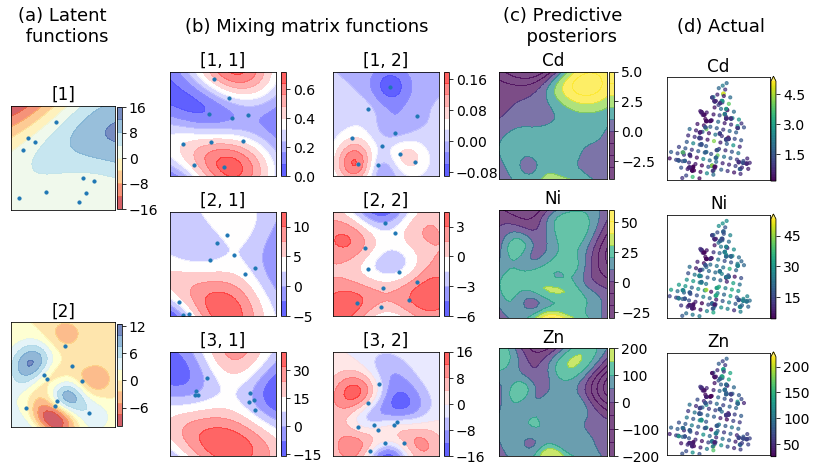

In [11]:
# create grid co-ordinates
x1min = 0.5;x1max = 6.0;x2min =0.5;x2max = 6.0;
xplot, yplot = np.meshgrid(np.linspace(x1min,x1max,30),np.linspace(x2min,x2max,30))
Xplot = np.concatenate([xplot.reshape(-1,1),yplot.reshape(-1,1)],axis=1)

# predictions
pred_plt_wfmean = wfmean.eval({X:Xplot})
pred_plt_fmean = fmean.eval({X:Xplot})
pred_plt_wmean = wmean.eval({X:Xplot})

# inducing locations and values
ind_plot_f = [Zf_list[i].get_tfv().eval() 
              for i in range(num_latent)]
ind_plot_w = [[Zw_list[j][i].get_tfv().eval()
              for i in range(num_output)]
              for j in range(num_latent)]

plot_gprn_fit(Xtrain,Ytrain,xplot,yplot,pred_plt_wfmean,pred_plt_fmean,pred_plt_wmean,ind_plot_f,ind_plot_w)

**Train set predictions**

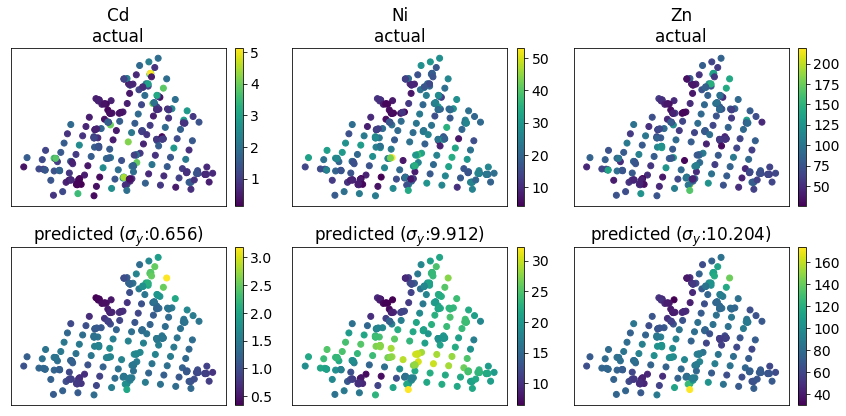

In [12]:
mpl.rcParams['figure.figsize'] = (12,6)
fig, ax = plt.subplots(2,3,sharex='all', sharey='all')

pred_trn_wfmean = wfmean.eval({X:Xtrain})

names = ["Cd","Ni","Zn"]
for i in range(3):
    cnorm = mpl.colors.Normalize(vmin=0.,vmax=Ytrain[:,i].max())
    
    cx1 = ax[0,i].scatter(Xtrain[:,0],Xtrain[:,1],c=Ytrain[:,i]) 
    cbar1 = fig.colorbar(cx1,ax=ax[0,i],fraction=0.046, pad=0.04)
    ax[0,i].set_title(names[i]+"\n"+"actual")
    ax[0,i].xaxis.set_ticks([])
    ax[0,i].yaxis.set_ticks([])

    cx2 = ax[1,i].scatter(Xtrain[:,0],Xtrain[:,1],c=pred_trn_wfmean[:,i]) 
    cbar2 = fig.colorbar(cx2,ax=ax[1,i],fraction=0.046, pad=0.04)
    ax[1,i].set_title("predicted ("+r"$\sigma_y$:"+str(np.round(noisevar_list[i].get_tfv().eval(),3))+")")
    ax[1,i].xaxis.set_ticks([])
    ax[1,i].yaxis.set_ticks([])

fig.tight_layout()
plt.show()

In [13]:
print("train mse:",np.sqrt(np.mean((pred_trn_wfmean - Ytrain)**2,axis=0)))
print("train mae:",np.mean(np.abs(pred_trn_wfmean - Ytrain),axis=0))

train mse: [  0.77901107   5.34701955  19.93367382]
train mae: [  0.56083544   4.12469146  14.56524853]
